In [25]:
import utils
import torch
from tqdm import tqdm
from torchvision import datasets, transforms
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import nbformat
import os
import collections
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import seaborn as sns

checkpoint_path = 'weights/checkpoint_32x32BN.pth'
RESUME_TRAINING = False

PRINT_IMG = True
AUGMENT_DATASET = False
TRANSFORM_DATASET = False

OPTIMIZER='SGD'

### Hyperparameters ###
BATCH_SIZE = 128
LEARNING_RATE = 0.001
MOMENTUM = 0.9
EPOCHS = 30

WEIGHT_DECAY = 0

### Early Stopping ###
EARLY_STOPPING = True
ES_PATIENCE = 5

SEED = 0

random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [2]:
train_dataset, train_dataset_raw = utils.create_train_dataset(TRANSFORM_DATASET, AUGMENT_DATASET)
test_dataset, validation_dataset, test_dataset_raw = utils.create_test_dataset(validation_split=0.7)

/home/andrea/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Dimensione del dataset originale: 60000
Dimensione del dataset trasformato: 60000


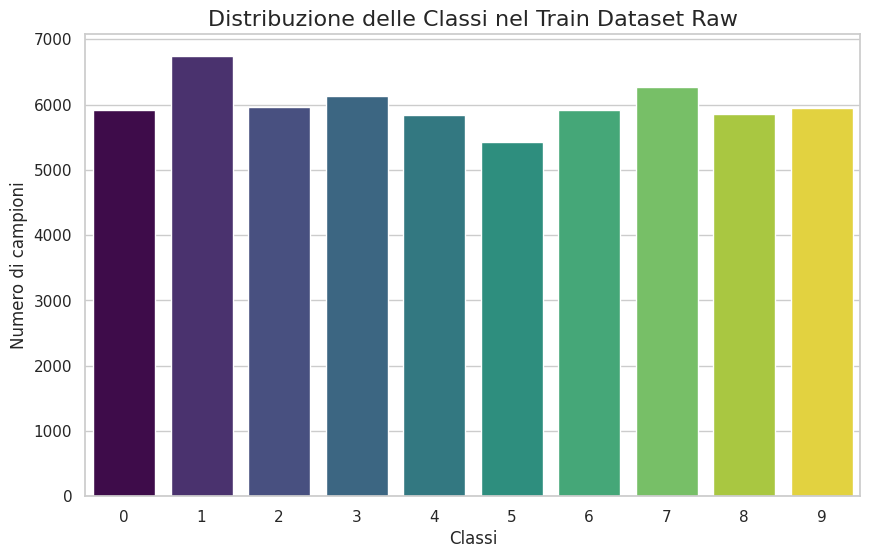

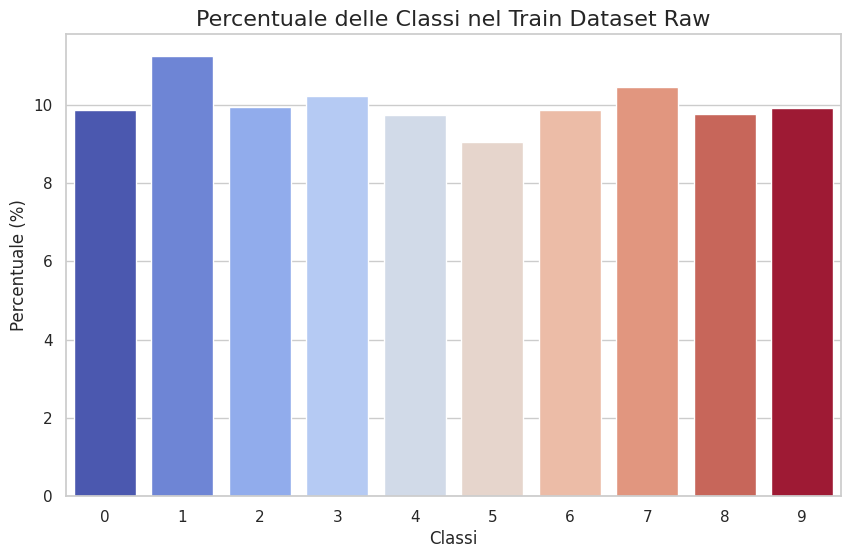

In [3]:
utils.plot_dataset_raw_statistics(train_dataset_raw, "Train Dataset Raw")

Numero totale di campioni: 60000
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 20000, 1: 20000, 2: 20000}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 0: 20000 campioni (33.33%)
Relazione 1: 20000 campioni (33.33%)
Relazione 2: 20000 campioni (33.33%)




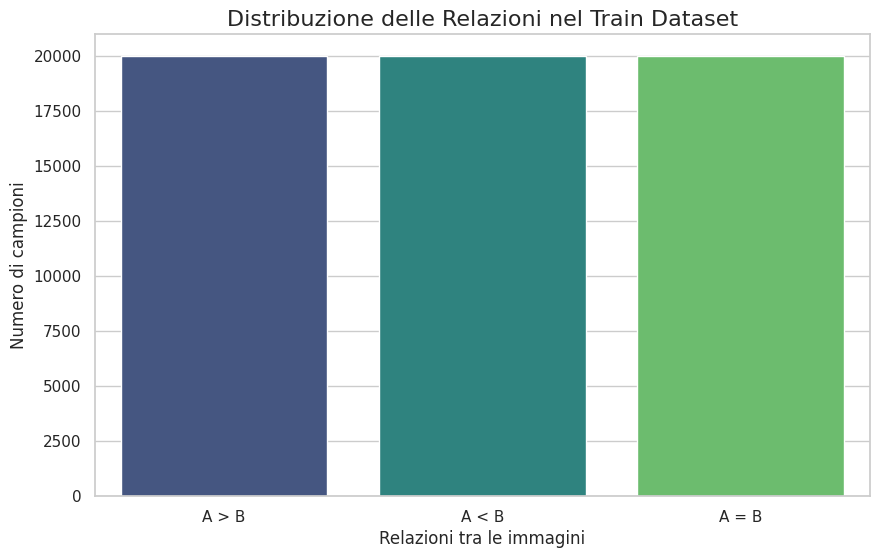

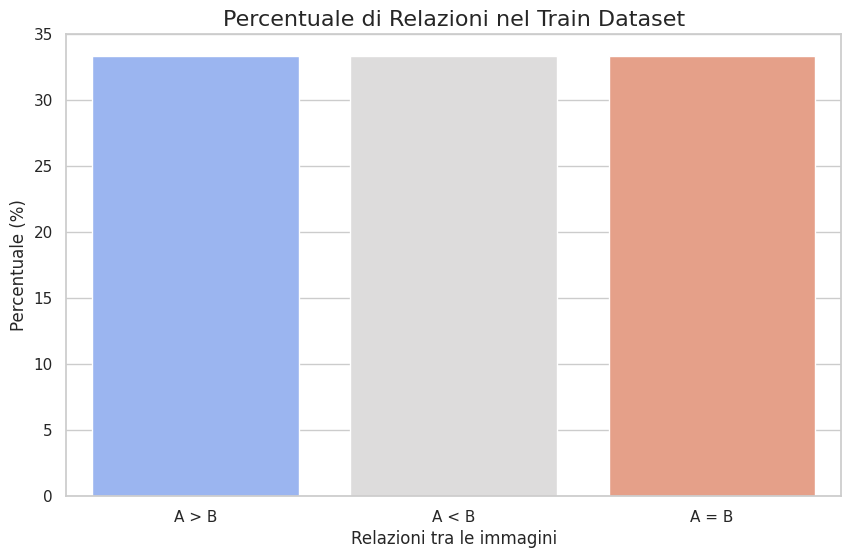

In [4]:
utils.plot_dataset_statistics(train_dataset, dataset_name="Train Dataset")

Numero totale di campioni: 3000
Distribuzione delle relazioni (A > B, A < B, A = B): {1: 990, 2: 1021, 0: 989}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 1: 990 campioni (33.00%)
Relazione 2: 1021 campioni (34.03%)
Relazione 0: 989 campioni (32.97%)




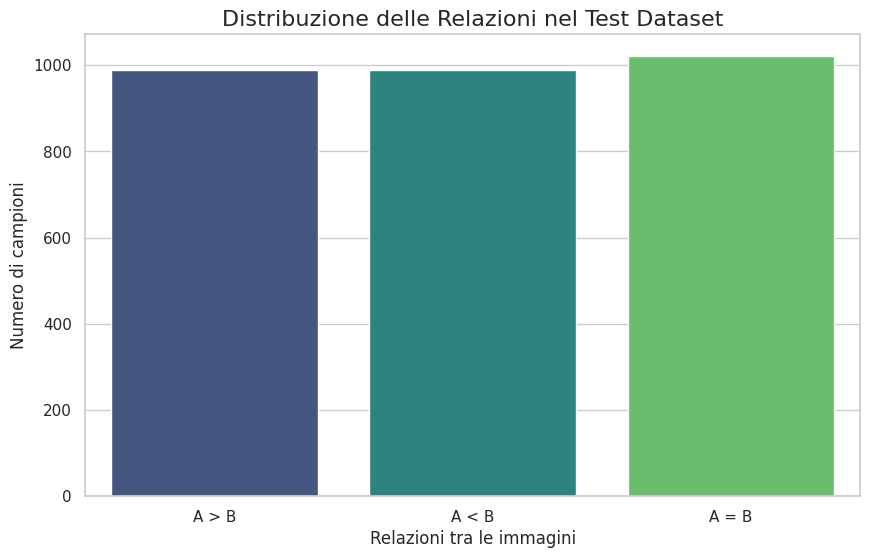

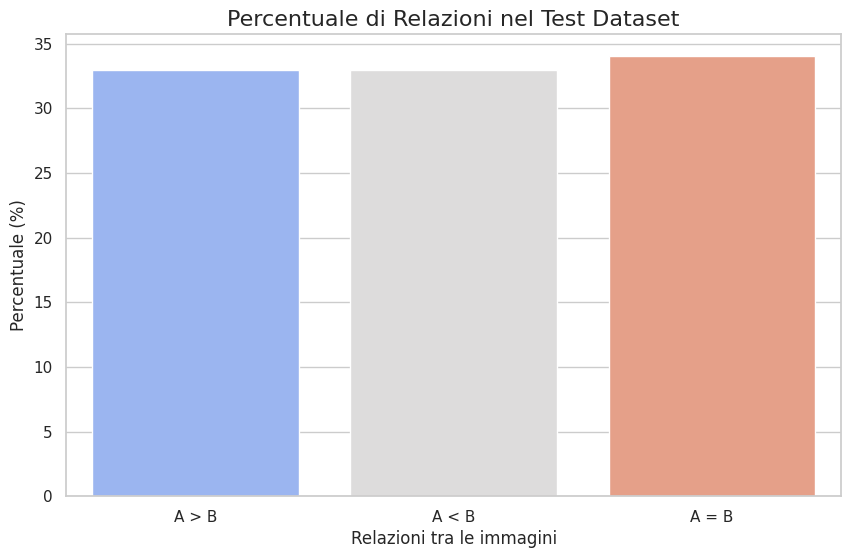

In [5]:
utils.plot_dataset_statistics(test_dataset, dataset_name="Test Dataset")

Numero totale di campioni: 6999
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 2344, 1: 2343, 2: 2312}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 0: 2344 campioni (33.49%)
Relazione 1: 2343 campioni (33.48%)
Relazione 2: 2312 campioni (33.03%)




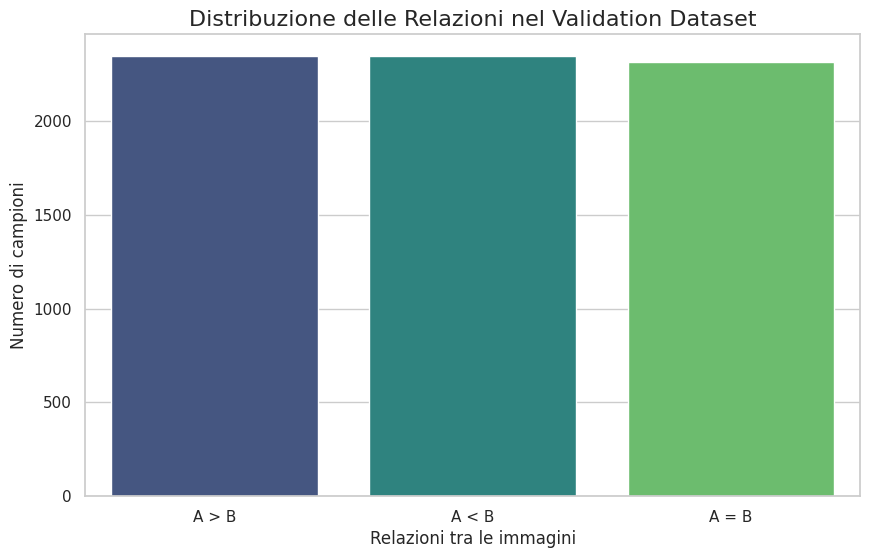

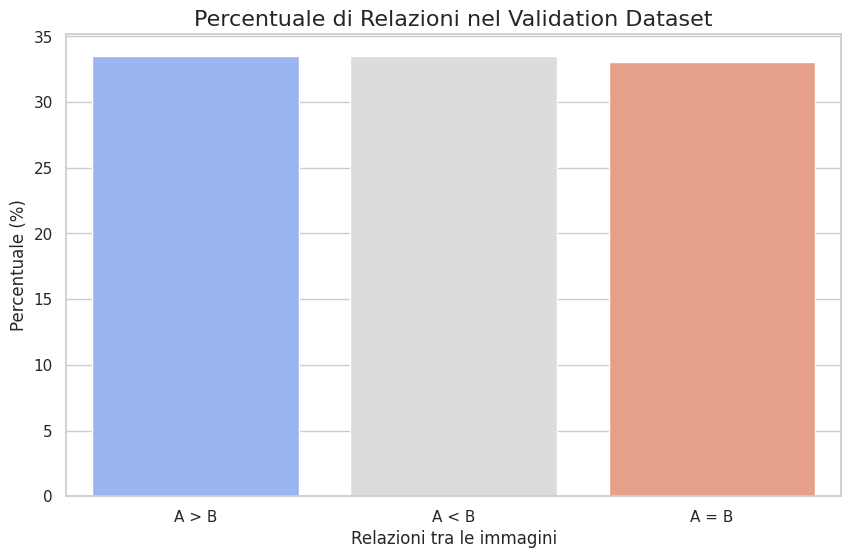

In [6]:
utils.plot_dataset_statistics(validation_dataset, dataset_name="Validation Dataset")

In [7]:
train_loader, validation_loader, test_loader = utils.create_data_loader(train_dataset, validation_dataset, test_dataset, BATCH_SIZE)

In [8]:
print("Size train_loader: ", len(train_loader), " Size train_dataset: ", len(train_dataset))
print("Size validation_loader: ", len(validation_loader), " Size validation_dataset: ", len(validation_dataset))
print("Size test_loader: ", len(test_loader), " Size test_dataset: ", len(test_dataset))

Size train_loader:  469  Size train_dataset:  60000
Size validation_loader:  55  Size validation_dataset:  6999
Size test_loader:  24  Size test_dataset:  3000


In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [27]:
class CustomLeNet5(nn.Module):
    def __init__(self):
        super(CustomLeNet5, self).__init__()
        
        # Convolutional layers with Batch Normalization
        self.conv1 = nn.Conv2d(2, 6, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(6)  # BatchNorm for first conv layer
        
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(16)  # BatchNorm for second conv layer
        
        # Fully connected layers with Batch Normalization
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.bn3 = nn.BatchNorm1d(120)  # BatchNorm for first FC layer
        
        self.fc2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)  # BatchNorm for second FC layer
        
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        # Convolutional layers with ReLU and MaxPooling
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        
        # Flatten the tensor
        x = x.view(-1, 16 * 5 * 5)
        
        # Fully connected layers with ReLU
        x = F.relu(self.bn3(self.fc1(x)))
        x = F.relu(self.bn4(self.fc2(x)))
        
        # Output layer
        x = self.fc3(x)
        return x

# Instantiate the model
model = CustomLeNet5()
print(model)

CustomLeNet5(
  (conv1): Conv2d(2, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (bn3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (bn4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)


In [28]:
# Definisci la funzione di perdita e l'ottimizzatore
criterion = nn.CrossEntropyLoss()
if OPTIMIZER == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
elif OPTIMIZER == 'ADAM':
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

images dtype: torch.float32, labels dtype: torch.int64


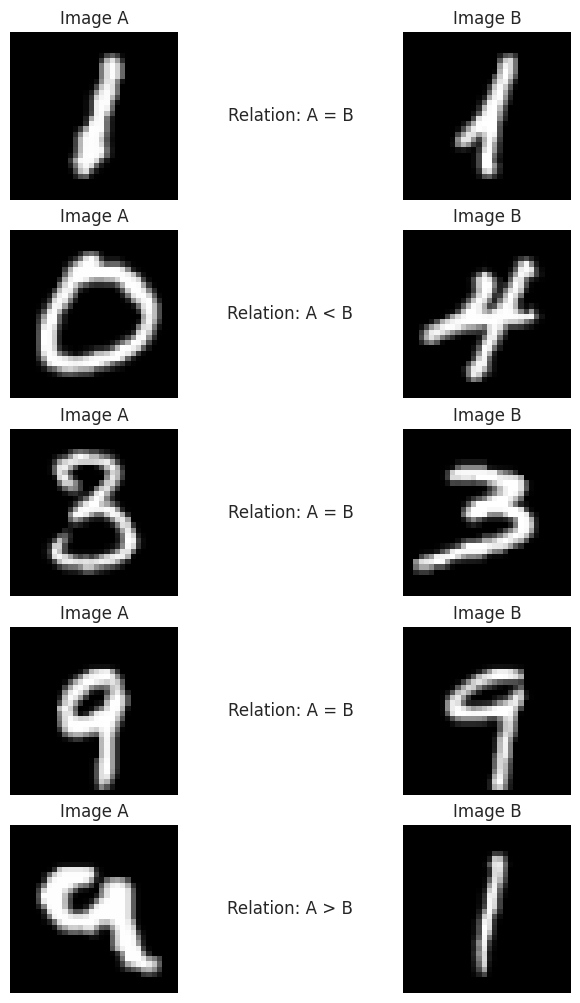

In [29]:

if OPTIMIZER == 'SGD':
    fileName = f"runs/log32x32BN_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_m={MOMENTUM}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"
elif OPTIMIZER == 'ADAM':
    fileName = f"runs/log32x32BN_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"

writer = SummaryWriter(fileName)

# Ottieni un batch dal dataloader
batch = next(iter(train_loader))
images, labels = batch

# Stampa il tipo di dato di ciascun tensore per debug
print(f"images dtype: {images.dtype}, labels dtype: {labels.dtype}")

writer.add_graph(model, next(iter(train_loader))[0])

writer.add_figure('Image_pair', utils.show_dataset(train_loader, 5))

In [30]:
# Definisci le liste per salvare i valori di loss e accuracy

def train(train_data_loader, model):
    print('Training')
    train_itr = 0
    correct_train = 0
    total_train = 0
    running_loss = 0.0
    train_loss_list = []
    train_accuracy_list = []
    
    # Inizializzazione della progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value

        train_loss_list.append(loss_value)
        train_accuracy_list.append(100 * correct_train / total_train)

        train_itr += 1
    
        # Aggiorna il valore della loss nella progress bar per ogni iterazione
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return running_loss / len(train_data_loader), 100 * correct_train / total_train, train_loss_list, train_accuracy_list

def validate(data_loader, model):
    print('Validating')
    val_itr = 0
    correct = 0
    total = 0
    running_loss = 0.0
    val_loss_list = []
    val_accuracy_list = []
    
    prog_bar = tqdm(data_loader, total=len(data_loader))
    
    for i, data in enumerate(prog_bar):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        with torch.no_grad():
            outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss_value = loss.item()
        running_loss += loss_value
        val_loss_list.append(loss_value)
        val_accuracy_list.append(100 * correct / total)
        val_itr += 1

        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return loss_value, 100 * correct / total, val_loss_list, val_accuracy_list

In [31]:
# TRAIN!!!
start_epoch = 0
if RESUME_TRAINING and os.path.exists(checkpoint_path):
    start_epoch, best_val_loss, patience_counter = utils.load_checkpoint(model, optimizer, scheduler, checkpoint_path)

model.train()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
total_val_loss = []
total_val_acc = []
total_train_loss = []
total_train_acc = []
lr_history = []
best_val_loss = float('inf')
for epoch in range(EPOCHS):
        print(f"\nEPOCH {epoch+1} of {EPOCHS}")

        start = time.time()
        train_loss, train_acc, train_loss_list, train_acc_list = train(train_loader, model)
        val_loss, val_acc, val_loss_list, val_acc_list = validate(validation_loader, model)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        total_train_loss.extend(train_loss_list)
        total_train_acc.extend(train_acc_list)
        total_val_loss.extend(val_loss_list)
        total_val_acc.extend(val_acc_list)

        scheduler.step(val_loss)

        lr_history.append(optimizer.param_groups[0]['lr'])

        print(f"Epoch #{epoch+1} train loss: {train_loss:.3f} train accuracy: {train_acc:.2f}")   
        print(f"Epoch #{epoch+1} validation loss: {val_loss:.3f} validation accuracy: {val_acc:.2f}")   
        end = time.time()
        print("Learning rate actual: ", optimizer.param_groups[0]['lr'])
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")
        writer.add_scalars('Loss', {
                'Train': train_loss,
                'Validation': val_loss
        }, epoch + 1)
        
        writer.add_scalars('Accuracy', {
                'Train': train_acc,
                'Validation': val_acc
        }, epoch + 1)

        if EARLY_STOPPING:
                if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        patience_counter = 0
                        best_model_state = model.state_dict()
                else:
                        patience_counter += 1
                        print(f"No improvement for {patience_counter} epoch(s).")
                if patience_counter >= ES_PATIENCE:
                        print(f"Early stopping triggered after {epoch+1} epochs.")
                        utils.save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, patience_counter, checkpoint_path)
                        break

        utils.save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, patience_counter, checkpoint_path)

if EARLY_STOPPING and 'best_model_state' in locals():
    model.load_state_dict(best_model_state)

# Valida il modello appena trainato con il test set
model.eval()
test_loss, test_acc, _, _ = validate(test_loader, model)
print(f"Test loss: {test_loss:.3f} Test accuracy: {test_acc:.2f}")
writer.add_scalar('Test Loss', test_loss)
writer.add_scalar('Test Accuracy', test_acc)



EPOCH 1 of 30
Training


Loss: 0.5589: 100%|██████████| 469/469 [00:15<00:00, 30.68it/s]


Validating


Loss: 0.7673: 100%|██████████| 55/55 [00:01<00:00, 50.09it/s]


Epoch #1 train loss: 0.768 train accuracy: 66.29
Epoch #1 validation loss: 0.767 validation accuracy: 75.84
Learning rate actual:  0.001
Took 0.273 minutes for epoch 1
Checkpoint saved at epoch 1.

EPOCH 2 of 30
Training


Loss: 0.5498: 100%|██████████| 469/469 [00:15<00:00, 30.84it/s]


Validating


Loss: 0.6666: 100%|██████████| 55/55 [00:00<00:00, 55.35it/s]


Epoch #2 train loss: 0.541 train accuracy: 78.15
Epoch #2 validation loss: 0.667 validation accuracy: 80.27
Learning rate actual:  0.001
Took 0.270 minutes for epoch 2
Checkpoint saved at epoch 2.

EPOCH 3 of 30
Training


Loss: 0.3840: 100%|██████████| 469/469 [00:15<00:00, 30.06it/s]


Validating


Loss: 0.5669: 100%|██████████| 55/55 [00:00<00:00, 60.68it/s]


Epoch #3 train loss: 0.443 train accuracy: 82.67
Epoch #3 validation loss: 0.567 validation accuracy: 83.77
Learning rate actual:  0.001
Took 0.275 minutes for epoch 3
Checkpoint saved at epoch 3.

EPOCH 4 of 30
Training


Loss: 0.4583: 100%|██████████| 469/469 [00:16<00:00, 28.93it/s]


Validating


Loss: 0.4888: 100%|██████████| 55/55 [00:01<00:00, 49.45it/s]


Epoch #4 train loss: 0.378 train accuracy: 85.69
Epoch #4 validation loss: 0.489 validation accuracy: 85.68
Learning rate actual:  0.001
Took 0.289 minutes for epoch 4
Checkpoint saved at epoch 4.

EPOCH 5 of 30
Training


Loss: 0.3010: 100%|██████████| 469/469 [00:16<00:00, 28.73it/s]


Validating


Loss: 0.4049: 100%|██████████| 55/55 [00:01<00:00, 48.52it/s]


Epoch #5 train loss: 0.330 train accuracy: 87.58
Epoch #5 validation loss: 0.405 validation accuracy: 87.43
Learning rate actual:  0.001
Took 0.291 minutes for epoch 5
Checkpoint saved at epoch 5.

EPOCH 6 of 30
Training


Loss: 0.3311: 100%|██████████| 469/469 [00:16<00:00, 27.85it/s]


Validating


Loss: 0.4010: 100%|██████████| 55/55 [00:00<00:00, 55.38it/s]


Epoch #6 train loss: 0.294 train accuracy: 89.07
Epoch #6 validation loss: 0.401 validation accuracy: 87.98
Learning rate actual:  0.001
Took 0.297 minutes for epoch 6
Checkpoint saved at epoch 6.

EPOCH 7 of 30
Training


Loss: 0.2452: 100%|██████████| 469/469 [00:16<00:00, 28.59it/s]


Validating


Loss: 0.3615: 100%|██████████| 55/55 [00:00<00:00, 56.56it/s]


Epoch #7 train loss: 0.263 train accuracy: 90.28
Epoch #7 validation loss: 0.362 validation accuracy: 89.26
Learning rate actual:  0.001
Took 0.290 minutes for epoch 7
Checkpoint saved at epoch 7.

EPOCH 8 of 30
Training


Loss: 0.2280: 100%|██████████| 469/469 [00:15<00:00, 29.78it/s]


Validating


Loss: 0.3563: 100%|██████████| 55/55 [00:00<00:00, 58.53it/s]


Epoch #8 train loss: 0.238 train accuracy: 91.23
Epoch #8 validation loss: 0.356 validation accuracy: 89.14
Learning rate actual:  0.001
Took 0.278 minutes for epoch 8
Checkpoint saved at epoch 8.

EPOCH 9 of 30
Training


Loss: 0.2276: 100%|██████████| 469/469 [00:15<00:00, 29.95it/s]


Validating


Loss: 0.3156: 100%|██████████| 55/55 [00:01<00:00, 46.64it/s]


Epoch #9 train loss: 0.217 train accuracy: 92.16
Epoch #9 validation loss: 0.316 validation accuracy: 89.73
Learning rate actual:  0.001
Took 0.281 minutes for epoch 9
Checkpoint saved at epoch 9.

EPOCH 10 of 30
Training


Loss: 0.1917: 100%|██████████| 469/469 [00:15<00:00, 30.92it/s]


Validating


Loss: 0.3031: 100%|██████████| 55/55 [00:00<00:00, 59.40it/s]


Epoch #10 train loss: 0.201 train accuracy: 92.81
Epoch #10 validation loss: 0.303 validation accuracy: 89.98
Learning rate actual:  0.001
Took 0.268 minutes for epoch 10
Checkpoint saved at epoch 10.

EPOCH 11 of 30
Training


Loss: 0.1308: 100%|██████████| 469/469 [00:15<00:00, 30.87it/s]


Validating


Loss: 0.2982: 100%|██████████| 55/55 [00:00<00:00, 59.35it/s]


Epoch #11 train loss: 0.186 train accuracy: 93.39
Epoch #11 validation loss: 0.298 validation accuracy: 90.44
Learning rate actual:  0.001
Took 0.269 minutes for epoch 11
Checkpoint saved at epoch 11.

EPOCH 12 of 30
Training


Loss: 0.1197: 100%|██████████| 469/469 [00:15<00:00, 31.23it/s]


Validating


Loss: 0.2756: 100%|██████████| 55/55 [00:01<00:00, 53.29it/s]


Epoch #12 train loss: 0.174 train accuracy: 93.89
Epoch #12 validation loss: 0.276 validation accuracy: 90.10
Learning rate actual:  0.001
Took 0.268 minutes for epoch 12
Checkpoint saved at epoch 12.

EPOCH 13 of 30
Training


Loss: 0.1425: 100%|██████████| 469/469 [00:15<00:00, 30.36it/s]


Validating


Loss: 0.2479: 100%|██████████| 55/55 [00:00<00:00, 60.84it/s]


Epoch #13 train loss: 0.161 train accuracy: 94.24
Epoch #13 validation loss: 0.248 validation accuracy: 90.71
Learning rate actual:  0.001
Took 0.273 minutes for epoch 13
Checkpoint saved at epoch 13.

EPOCH 14 of 30
Training


Loss: 0.0712: 100%|██████████| 469/469 [00:14<00:00, 31.41it/s]


Validating


Loss: 0.2698: 100%|██████████| 55/55 [00:00<00:00, 58.29it/s]


Epoch #14 train loss: 0.149 train accuracy: 94.67
Epoch #14 validation loss: 0.270 validation accuracy: 90.90
Learning rate actual:  0.001
Took 0.265 minutes for epoch 14
No improvement for 1 epoch(s).
Checkpoint saved at epoch 14.

EPOCH 15 of 30
Training


Loss: 0.1839: 100%|██████████| 469/469 [00:15<00:00, 31.03it/s]


Validating


Loss: 0.2706: 100%|██████████| 55/55 [00:00<00:00, 60.97it/s]


Epoch #15 train loss: 0.138 train accuracy: 95.17
Epoch #15 validation loss: 0.271 validation accuracy: 91.57
Learning rate actual:  0.001
Took 0.267 minutes for epoch 15
No improvement for 2 epoch(s).
Checkpoint saved at epoch 15.

EPOCH 16 of 30
Training


Loss: 0.1462: 100%|██████████| 469/469 [00:15<00:00, 31.12it/s]


Validating


Loss: 0.2419: 100%|██████████| 55/55 [00:01<00:00, 51.44it/s]


Epoch #16 train loss: 0.131 train accuracy: 95.39
Epoch #16 validation loss: 0.242 validation accuracy: 91.51
Learning rate actual:  0.001
Took 0.269 minutes for epoch 16
Checkpoint saved at epoch 16.

EPOCH 17 of 30
Training


Loss: 0.1595: 100%|██████████| 469/469 [00:15<00:00, 30.98it/s]


Validating


Loss: 0.2251: 100%|██████████| 55/55 [00:00<00:00, 60.02it/s]


Epoch #17 train loss: 0.123 train accuracy: 95.70
Epoch #17 validation loss: 0.225 validation accuracy: 91.53
Learning rate actual:  0.001
Took 0.268 minutes for epoch 17
Checkpoint saved at epoch 17.

EPOCH 18 of 30
Training


Loss: 0.1095: 100%|██████████| 469/469 [00:15<00:00, 29.37it/s]


Validating


Loss: 0.2489: 100%|██████████| 55/55 [00:01<00:00, 46.28it/s]


Epoch #18 train loss: 0.113 train accuracy: 96.13
Epoch #18 validation loss: 0.249 validation accuracy: 91.74
Learning rate actual:  0.001
Took 0.286 minutes for epoch 18
No improvement for 1 epoch(s).
Checkpoint saved at epoch 18.

EPOCH 19 of 30
Training


Loss: 0.1046: 100%|██████████| 469/469 [00:16<00:00, 27.74it/s]


Validating


Loss: 0.2598: 100%|██████████| 55/55 [00:00<00:00, 58.01it/s]


Epoch #19 train loss: 0.108 train accuracy: 96.26
Epoch #19 validation loss: 0.260 validation accuracy: 91.17
Learning rate actual:  0.001
Took 0.298 minutes for epoch 19
No improvement for 2 epoch(s).
Checkpoint saved at epoch 19.

EPOCH 20 of 30
Training


Loss: 0.0742: 100%|██████████| 469/469 [00:15<00:00, 30.48it/s]


Validating


Loss: 0.1867: 100%|██████████| 55/55 [00:01<00:00, 47.14it/s]


Epoch #20 train loss: 0.101 train accuracy: 96.50
Epoch #20 validation loss: 0.187 validation accuracy: 91.88
Learning rate actual:  0.001
Took 0.276 minutes for epoch 20
Checkpoint saved at epoch 20.

EPOCH 21 of 30
Training


Loss: 0.1293: 100%|██████████| 469/469 [00:14<00:00, 31.51it/s]


Validating


Loss: 0.2134: 100%|██████████| 55/55 [00:00<00:00, 60.00it/s]


Epoch #21 train loss: 0.096 train accuracy: 96.70
Epoch #21 validation loss: 0.213 validation accuracy: 91.98
Learning rate actual:  0.001
Took 0.264 minutes for epoch 21
No improvement for 1 epoch(s).
Checkpoint saved at epoch 21.

EPOCH 22 of 30
Training


Loss: 0.1402: 100%|██████████| 469/469 [00:14<00:00, 32.93it/s]


Validating


Loss: 0.2779: 100%|██████████| 55/55 [00:00<00:00, 66.69it/s]


Epoch #22 train loss: 0.089 train accuracy: 97.00
Epoch #22 validation loss: 0.278 validation accuracy: 91.47
Learning rate actual:  0.001
Took 0.251 minutes for epoch 22
No improvement for 2 epoch(s).
Checkpoint saved at epoch 22.

EPOCH 23 of 30
Training


Loss: 0.0420: 100%|██████████| 469/469 [00:14<00:00, 32.63it/s]


Validating


Loss: 0.1907: 100%|██████████| 55/55 [00:00<00:00, 57.50it/s]


Epoch #23 train loss: 0.084 train accuracy: 97.23
Epoch #23 validation loss: 0.191 validation accuracy: 92.08
Learning rate actual:  0.001
Took 0.256 minutes for epoch 23
No improvement for 3 epoch(s).
Checkpoint saved at epoch 23.

EPOCH 24 of 30
Training


Loss: 0.1589: 100%|██████████| 469/469 [00:14<00:00, 32.97it/s]


Validating


Loss: 0.2220: 100%|██████████| 55/55 [00:00<00:00, 67.23it/s]


Epoch #24 train loss: 0.078 train accuracy: 97.43
Epoch #24 validation loss: 0.222 validation accuracy: 91.90
Learning rate actual:  0.001
Took 0.251 minutes for epoch 24
No improvement for 4 epoch(s).
Checkpoint saved at epoch 24.

EPOCH 25 of 30
Training


Loss: 0.1179: 100%|██████████| 469/469 [00:14<00:00, 33.29it/s]


Validating


Loss: 0.2347: 100%|██████████| 55/55 [00:00<00:00, 59.29it/s]


Epoch #25 train loss: 0.074 train accuracy: 97.56
Epoch #25 validation loss: 0.235 validation accuracy: 91.84
Learning rate actual:  0.001
Took 0.250 minutes for epoch 25
No improvement for 5 epoch(s).
Early stopping triggered after 25 epochs.
Checkpoint saved at epoch 25.
Validating


Loss: 0.1560: 100%|██████████| 24/24 [00:00<00:00, 73.33it/s]


Test loss: 0.156 Test accuracy: 91.30


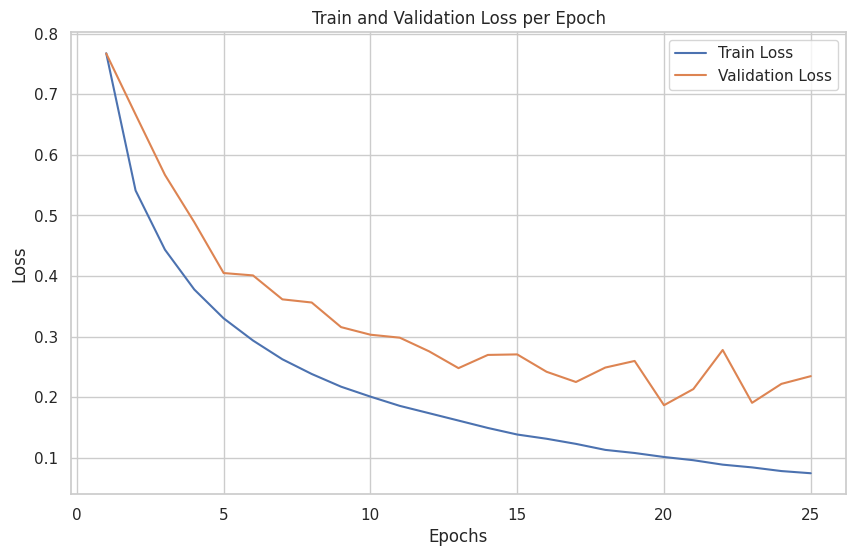

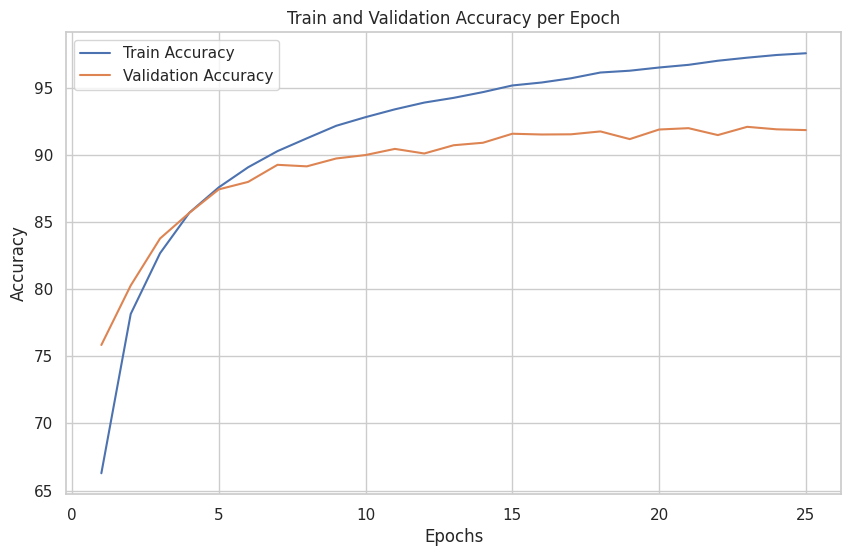

In [32]:
utils.plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies,
                        total_train_loss, total_val_loss, total_train_acc, total_val_acc)

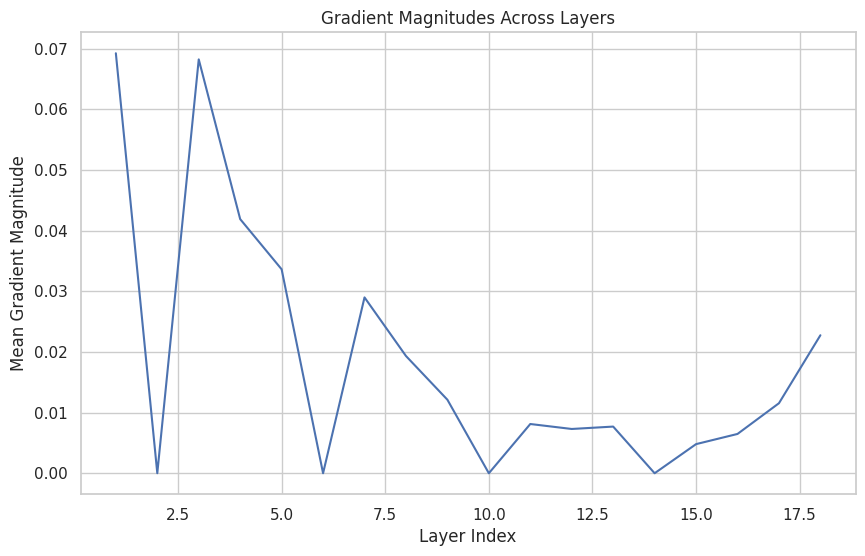

In [33]:
utils.plot_gradient(model)

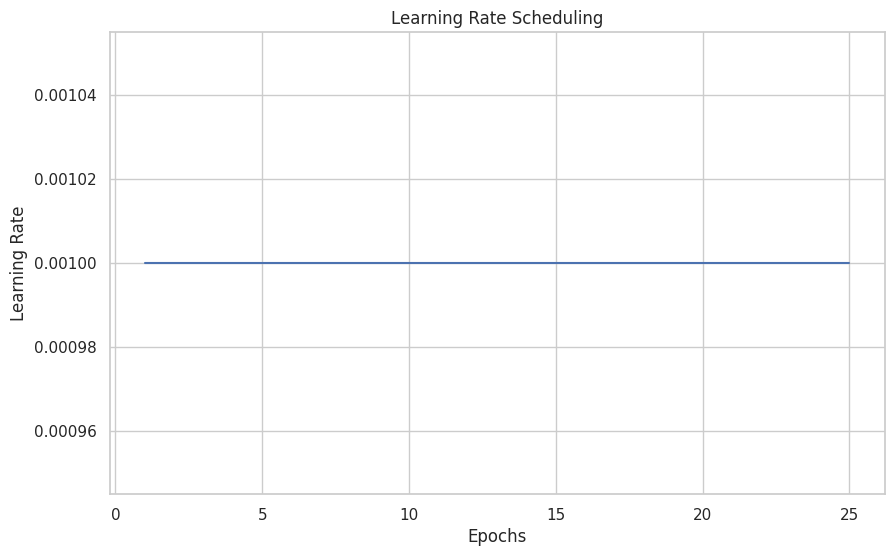

In [34]:
utils.plot_lr_scheduler(lr_history)

In [35]:
all_preds_val, all_labels_val, all_images_A_val, all_images_B_val = utils.inference(model, validation_loader, device)
all_preds_test, all_labels_test, all_images_A_test, all_images_B_test = utils.inference(model, test_loader, device)

541 previsioni errate trovate.


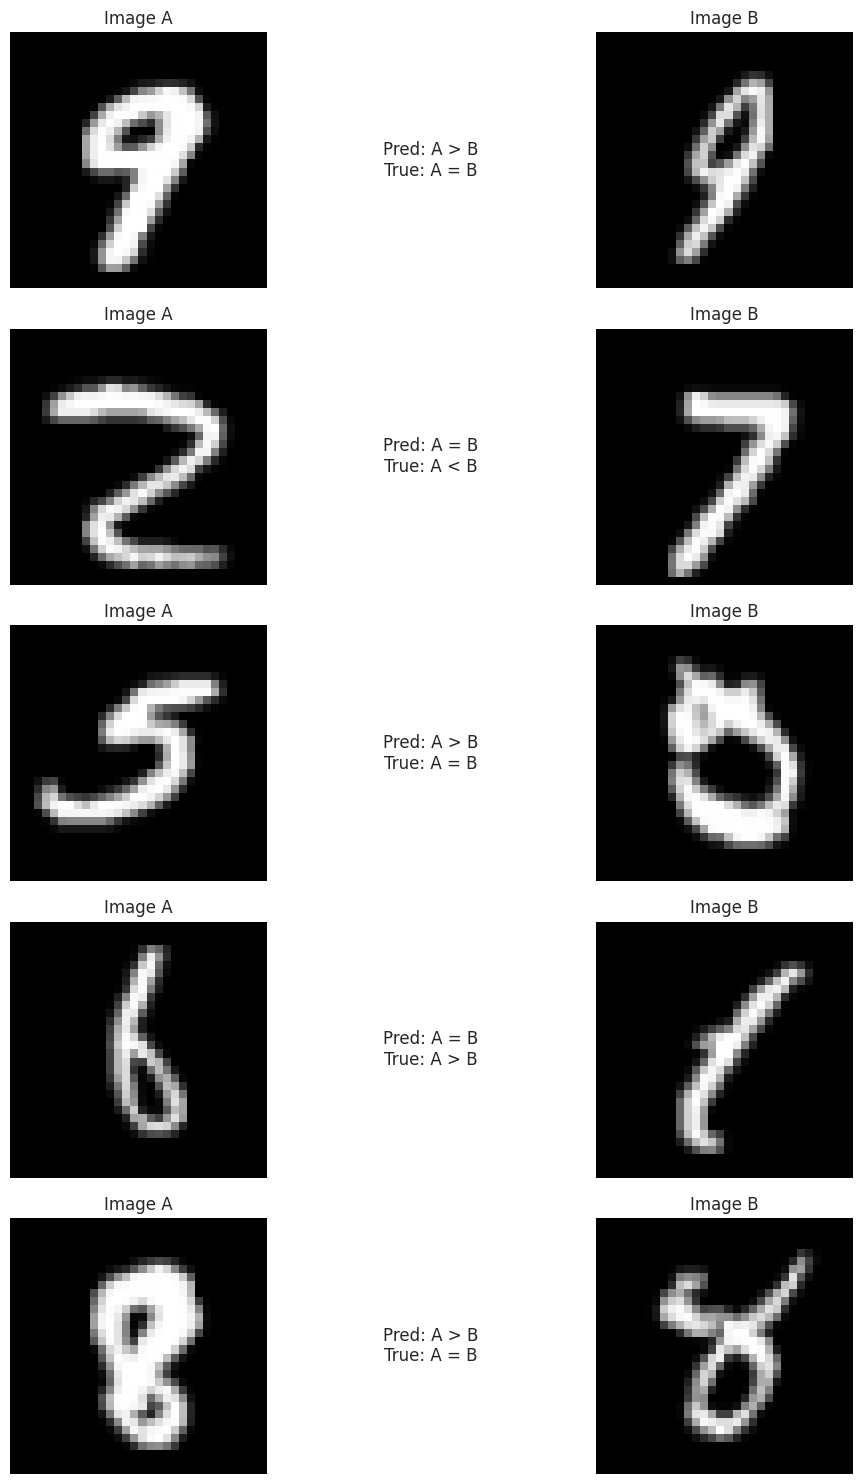

In [36]:
# Visualizza alcune previsioni errate
writer.add_figure('Incorrect_predictions_validation', utils.show_incorrect_predictions(all_preds_val, all_labels_val, all_images_A_val, all_images_B_val, num_images=5))

In [ ]:
# Visualizza alcune previsioni errate
writer.add_figure('Incorrect_predictions_test', utils.show_incorrect_predictions(all_preds_test, all_labels_test, all_images_A_test, all_images_B_test, num_images=5))

261 previsioni errate trovate.


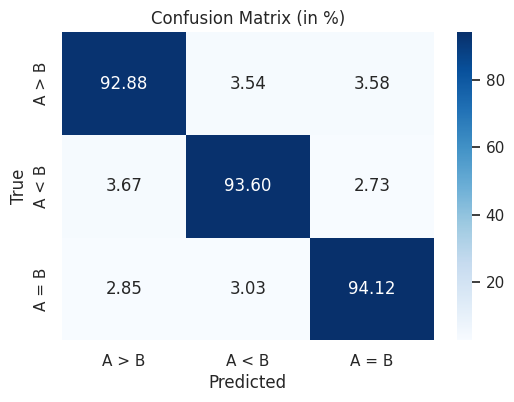

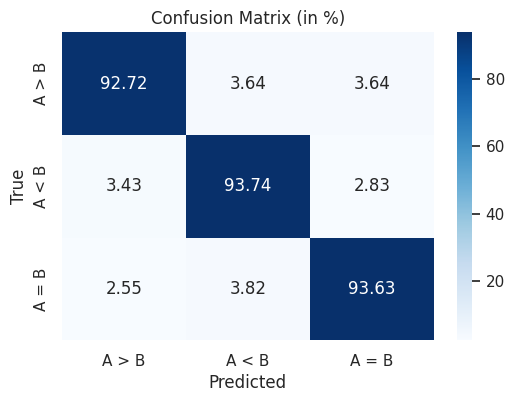

In [ ]:
# Calcola e visualizza la matrice di confusione
writer.add_figure('Confusion_matrix_validation', utils.plot_confusion_matrix(all_preds_val, all_labels_val))
writer.add_figure('Confusion_matrix_test', utils.plot_confusion_matrix(all_preds_test, all_labels_test))


In [ ]:
# Stampa il report delle metriche
utils.classification_metrics(all_preds_test, all_labels_test)

              precision    recall  f1-score   support

       A > B       0.94      0.93      0.93       989
       A < B       0.93      0.94      0.93       990
       A = B       0.94      0.94      0.94      1021

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000



Precision: Il numero di veri positivi diviso per il numero di esempi che sono stati predetti come positivi.
Recall (Sensibilità): Il numero di veri positivi diviso per il numero di esempi che appartengono effettivamente alla classe positiva.
F1-Score: La media armonica tra precisione e recall. È utile quando hai un dataset squilibrato.
Support: Il numero di campioni effettivi per ogni classe.

In [ ]:
def save_notebook_copy(notebook_name='main.ipynb'):
    # Leggi il notebook attuale
    with open(notebook_name, 'r') as f:
        notebook_content = nbformat.read(f, as_version=4)
    
    # Costruisci il nome base del nuovo notebook
    if OPTIMIZER == 'SGD':
        base_name = f"run32x32BN_BS={BATCH_SIZE}_LR={LEARNING_RATE}_MOM={MOMENTUM}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}"
    elif OPTIMIZER == 'ADAM':
        base_name = f"run32x32BN_BS={BATCH_SIZE}_LR={LEARNING_RATE}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}"
    else:
        base_name = "run32x32BN"

    # Aggiungi estensione .ipynb
    new_notebook_name = f"{base_name}.ipynb"

    # Evita sovrascritture aggiungendo un numero incrementale se il file esiste
    counter = 1
    while os.path.exists(new_notebook_name):
        new_notebook_name = f"{base_name}_{counter}.ipynb"
        counter += 1

    # Salva il notebook con il nuovo nome
    with open(new_notebook_name, 'w') as f:
        nbformat.write(notebook_content, f)
    
    print(f"Notebook saved as {new_notebook_name}")


# Specifica il nome del notebook attuale
save_notebook_copy('main_32x32_BN.ipynb')


Notebook saved as run32x32BN_BS=128_LR=0.002_MOM=0.9_EPOCHS=30_AUG=False_TRA=False_OPT=SGD.ipynb


In [ ]:
writer.close()